In [1]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'mejiro':
    path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [2]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rc

rc('font', **{'family':'serif', 'serif':['Computer Modern Roman'], 'monospace': ['Computer Modern Typewriter']})
rc('text', usetex=True)

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Plots import plot_util

from mejiro.helpers import test_physical_lens_2
# from mejiro.plots import plot

/data/bwedig/.conda/envs/pandeia/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
figure_dir = os.path.join(repo_path, 'figures', 'diagnostics', 'pixel_density_test')
array_dir = os.path.join(repo_path, 'output', 'arrays', 'diagnostics', 'pixel_density_test')

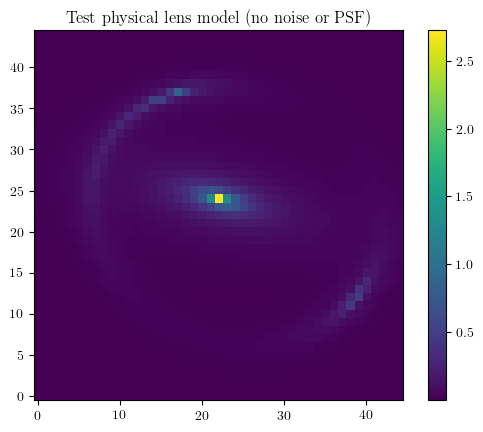

(45, 45)


In [4]:
physical_lens = test_physical_lens_2.TestPhysicalLens2()
num_pix = 45

test_model = physical_lens.get_array(num_pix=num_pix)

plt.imshow(test_model)
plt.title('Test physical lens model (no noise or PSF)')
plt.colorbar()
plt.show()

print(test_model.shape)

Overplot source and lens

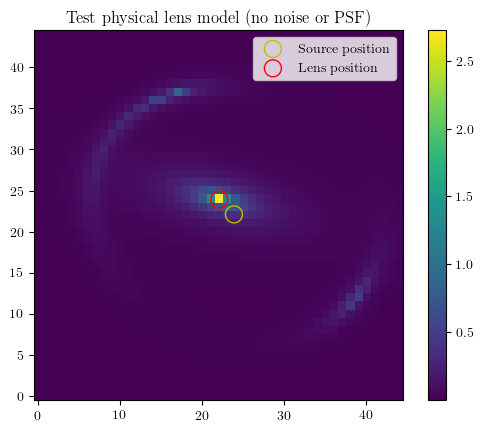

In [5]:
# get source pixel coordinates
source_x, source_y = physical_lens.get_source_pixel_coords()

# get lens pixel coordinates
lens_x, lens_y = physical_lens.get_lens_pixel_coords()

# overplot them
plt.scatter(source_x, source_y, edgecolor='y', facecolor='none', s=150, label='Source position')
plt.scatter(lens_x, lens_y, edgecolor='r', facecolor='none', s=150, label='Lens position')

plt.imshow(test_model)
plt.title('Test physical lens model (no noise or PSF)')
plt.legend()
plt.colorbar()
plt.show()

Overplot caustics and critical curve

0.1 -0.1
[ 4.48098798 -7.50872256]


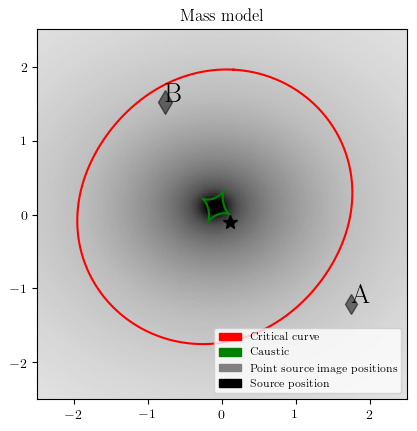

In [6]:
# source plane coordinates of source
beta_ra, beta_dec = physical_lens.kwargs_source[0]['center_x'], physical_lens.kwargs_source[0]['center_y']
print(beta_ra, beta_dec)

# specify the lens model class to deal with
solver = LensEquationSolver(physical_lens.lens_model_class)

# solve for image positions provided a lens model and the source position
theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, physical_lens.kwargs_lens_lensing_units)

# the magnification of the point source images
mag = physical_lens.lens_model_class.magnification(theta_ra, theta_dec, physical_lens.kwargs_lens_lensing_units)
print(mag)

# plot
f, axes = plt.subplots()
lens_plot.lens_model_plot(axes, lensModel=physical_lens.lens_model_class, kwargs_lens=physical_lens.kwargs_lens_lensing_units, sourcePos_x=beta_ra, sourcePos_y=beta_dec, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
axes.set_title('Mass model')
red_patch = mpatches.Patch(color='r', label='Critical curve')
blue_patch = mpatches.Patch(color='g', label='Caustic')
grey_patch = mpatches.Patch(color='grey', label='Point source image positions')
black_patch = mpatches.Patch(color='black', label='Source position')
axes.legend(loc=0, prop={'size': 8}, handles=[red_patch, blue_patch, grey_patch, black_patch])
axes.xaxis.set_ticks_position("bottom")
f.show()

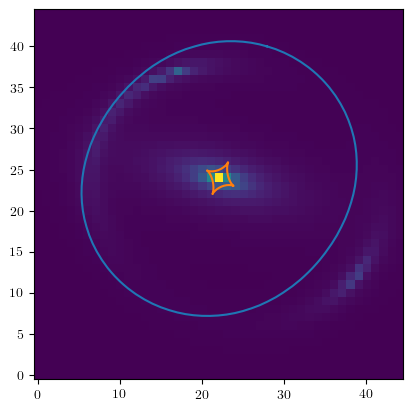

In [7]:
model_extension = LensModelExtensions(physical_lens.lens_model_class)

frame_size = physical_lens.delta_pix * num_pix

ra_critical_list, dec_critical_list, ra_caustic_list, dec_caustic_list = model_extension.critical_curve_caustics(physical_lens.kwargs_lens_lensing_units, compute_window=frame_size, grid_scale=physical_lens.delta_pix, center_x=0., center_y=0.)

x_critical_list, y_critical_list = [], []
for ra, dec in zip(ra_critical_list[0], dec_critical_list[0]):
    x, y = physical_lens.coords.map_coord2pix(ra=ra, dec=dec)
    x_critical_list.append(x)
    y_critical_list.append(y)

x_caustic_list, y_caustic_list = [], []
for ra, dec in zip(ra_caustic_list[0], dec_caustic_list[0]):
    x, y = physical_lens.coords.map_coord2pix(ra=ra, dec=dec)
    x_caustic_list.append(x)
    y_caustic_list.append(y)

fig, ax = plt.subplots()

ax.imshow(test_model)
ax.plot(x_critical_list, y_critical_list)
ax.plot(x_caustic_list, y_caustic_list)

ax.xaxis.set_ticks_position("bottom")

plt.show()

Combine

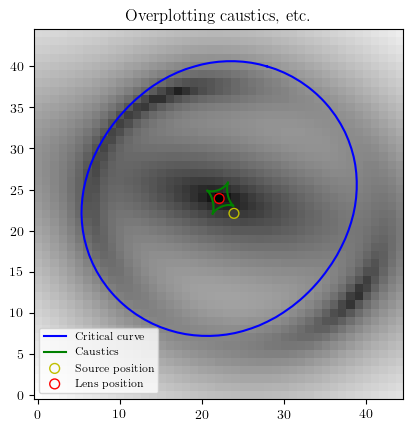

In [8]:
fig, ax = plt.subplots()

ax.imshow(np.log10(test_model), cmap='binary')
ax.plot(x_critical_list, y_critical_list, label='Critical curve', color='b')
ax.plot(x_caustic_list, y_caustic_list, label='Caustics', color='g')
ax.scatter(source_x, source_y, edgecolor='y', facecolor='none', s=50, label='Source position')
ax.scatter(lens_x, lens_y, edgecolor='r', facecolor='none', s=50, label='Lens position')

ax.legend(loc=0, prop={'size': 8})  # , handles=[red_patch, blue_patch, grey_patch, black_patch]
ax.xaxis.set_ticks_position("bottom")

plt.title('Overplotting caustics, etc.')
plt.show()

# Test `overplot.py`

In [9]:
from mejiro.plots import overplot

lens = test_physical_lens_2.TestPhysicalLens2()
num_pix = 45

model = lens.get_array(num_pix=num_pix)

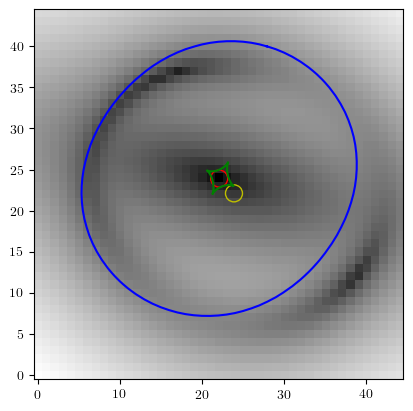

In [10]:
fig, ax = plt.subplots()

ax.imshow(np.log10(model), cmap='binary')

overplot.source_position(ax, lens)
overplot.lens_position(ax, lens)
overplot.caustics(ax, lens)
overplot.critical_curves(ax, lens)

plt.show()